
## 1. Why Transformers Need Positional Encoding

Unlike RNNs or CNNs, **Transformers do not process tokens sequentially**.  
They process all tokens in parallel using attention.

Therefore, **word order information must be injected explicitly**.

Let:
- Input sentence length = \(N\)
- Embedding dimension = \(d_{model}\)

Each token is mapped to an embedding:
The formula is:

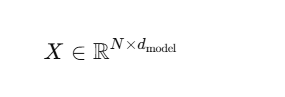



-  **(X)** The input embedding matrix to the Transformer (or self-attention layer).

- **(N) Sequence length**(number of tokens in the input text; e.g., words, subwords, or tokens)**

* **(d_{\text{model}})**
  Model (embedding) dimension
  (the size of the vector used to represent each token).



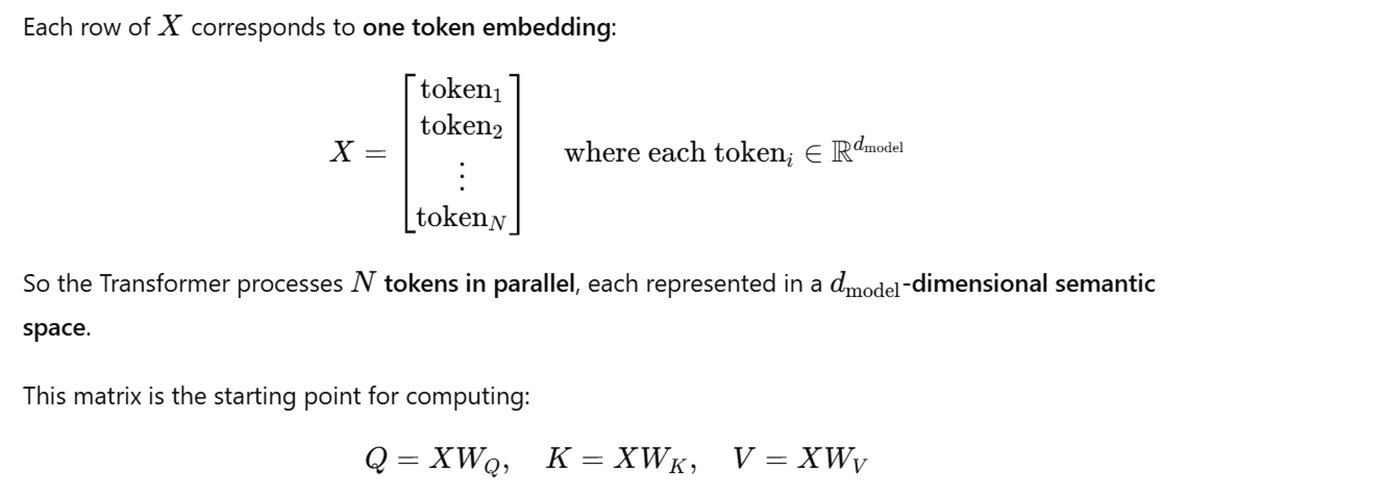
### Without positional encoding:
- "Dog bites man"  
- "Man bites dog"  

would be indistinguishable.


## 2. Sinusoidal Positional Encoding 

The original Transformer uses **fixed sinusoidal positional encodings**.

For position \(pos\) and dimension \(i\):
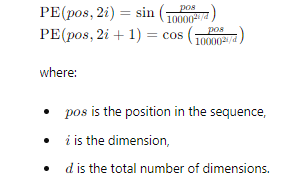

### Why sinusoids?
- Allow extrapolation to longer sequences
- Relative positions can be inferred via linear operations


In [1]:

import numpy as np

def positional_encoding(seq_len, d_model):
    pe = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                pe[pos, i + 1] = np.cos(pos / (10000 ** (i / d_model)))
    return pe

# Example
pe = positional_encoding(seq_len=10, d_model=16)
pe.shape


(10, 16)


## 3. Input Representation to the Transformer

Final input embedding:
\[
Z = X + PE
\]

Where:
- \(X\) = token embeddings
- \(PE\) = positional encodings

This sum injects **order information** without increasing dimensionality.


### 3. Example: "suyashi is happy"
- Let's consider a simple example where we encode a small part of the sequence using positional encoding. Assume the sentence "suyashi is happy" has four positions (0, 1, 2, 3), and we use a small dimension 
d=4 for simplicity.

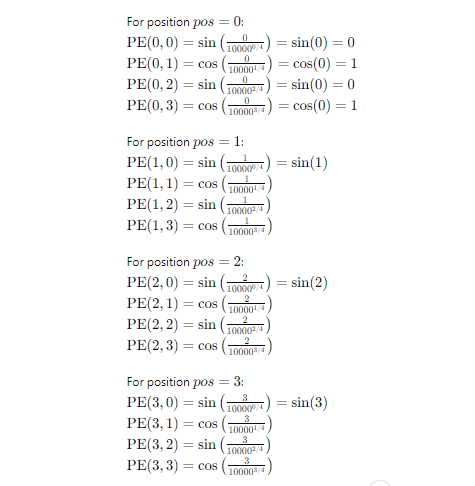

## Resulting Positional Encodings
Combining these, we get the positional encodings for each position
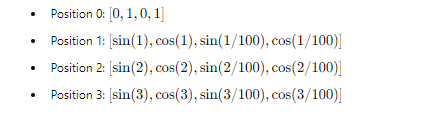
If the word embeddings for "suyashi", "is", "happy" are vectors, the positional encoding vectors would be added to these embeddings. This addition ensures that the model is aware of the position of each word in the sentence.
In practice, these operations are done over higher-dimensional spaces and with many more positions, but the fundamental idea remains the same. The positional encodings help the Transformer model understand the order and position of words within a sequence


## 4. Self-Attention: Core Idea

Each token attends to **every other token**, including itself.

For each token we compute:
- Query (Q)
- Key (K)
- Value (V)

Using learned projection matrices:
\[
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
\]

Where:
- \(W_Q, W_K, W_V \in \mathbb{R}^{d_{model} \times d_k}\)



## 5. Scaled Dot-Product Attention (Mathematics)

Attention is computed as:

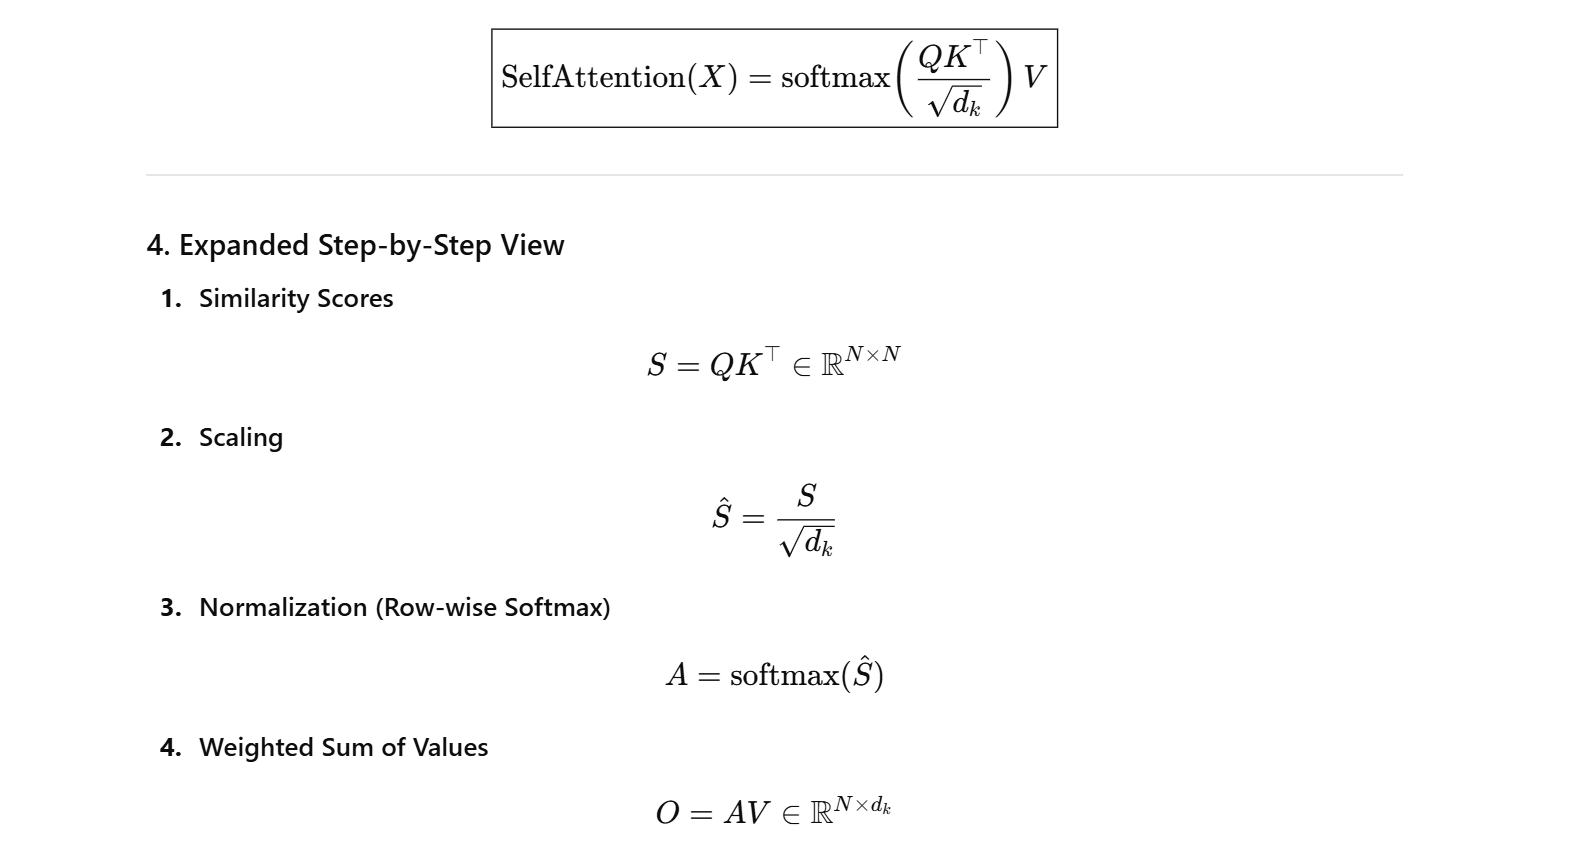



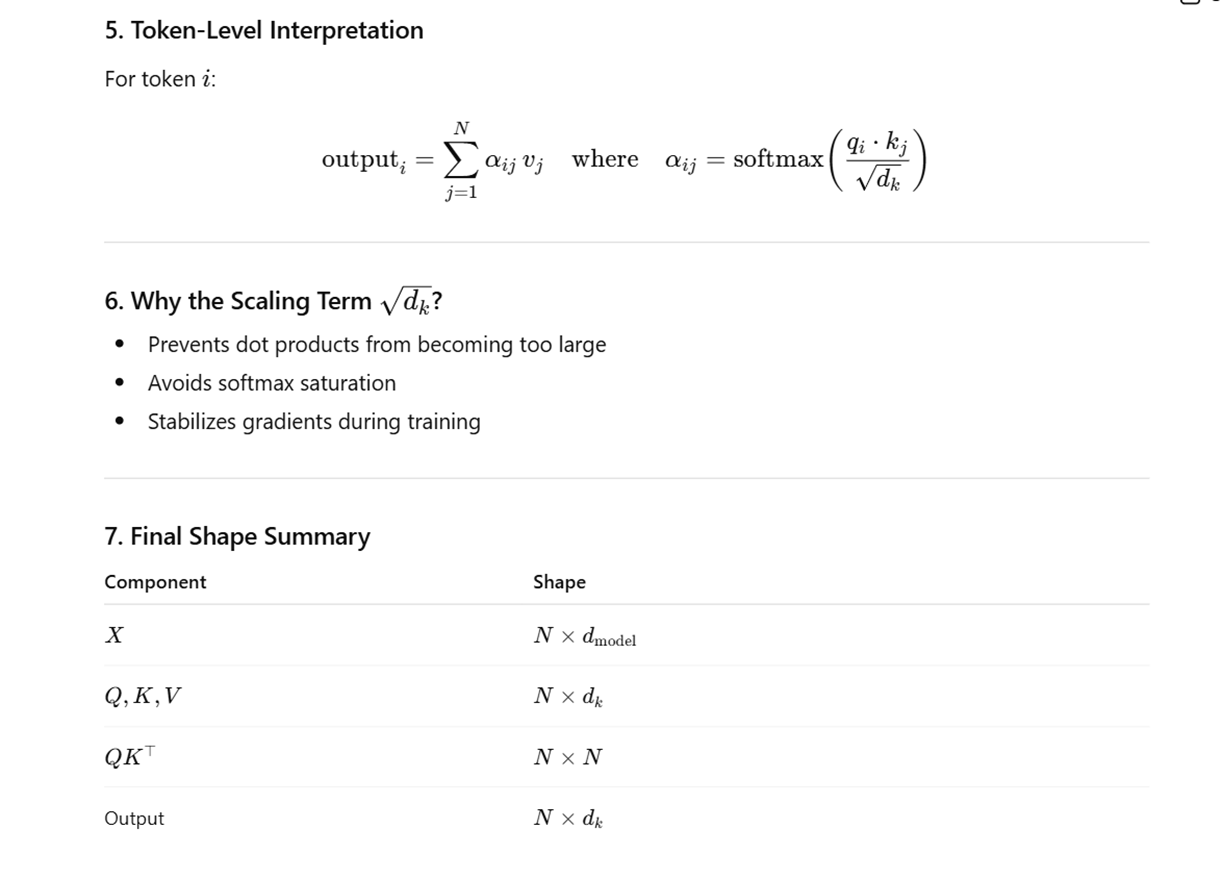

### Why scaling by \(\sqrt{d_k}\)?
- Prevents dot products from growing too large
- Stabilizes gradients during training


In [2]:

import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

# Toy example
torch.manual_seed(0)
X = torch.rand(1, 5, 8)  # (batch, seq_len, d_model)

W_Q = torch.rand(8, 8)
W_K = torch.rand(8, 8)
W_V = torch.rand(8, 8)

Q = X @ W_Q
K = X @ W_K
V = X @ W_V

out, attn_weights = scaled_dot_product_attention(Q, K, V)
out.shape, attn_weights.shape


(torch.Size([1, 5, 8]), torch.Size([1, 5, 5]))


## 6. Multi-Head Attention

A single self-attention head computes one attention pattern over the entire sequence.This is limiting because language has multiple simultaneous relationships, for example:

- syntactic dependency

- semantic similarity

- long-range references

- positional relationships

Multi-head attention allows the model to attend to different representation subspaces in parallel.



- Instead of performing one attention operation on the full embedding space:

- Perform h independent attention operations on smaller subspaces, then combine them.
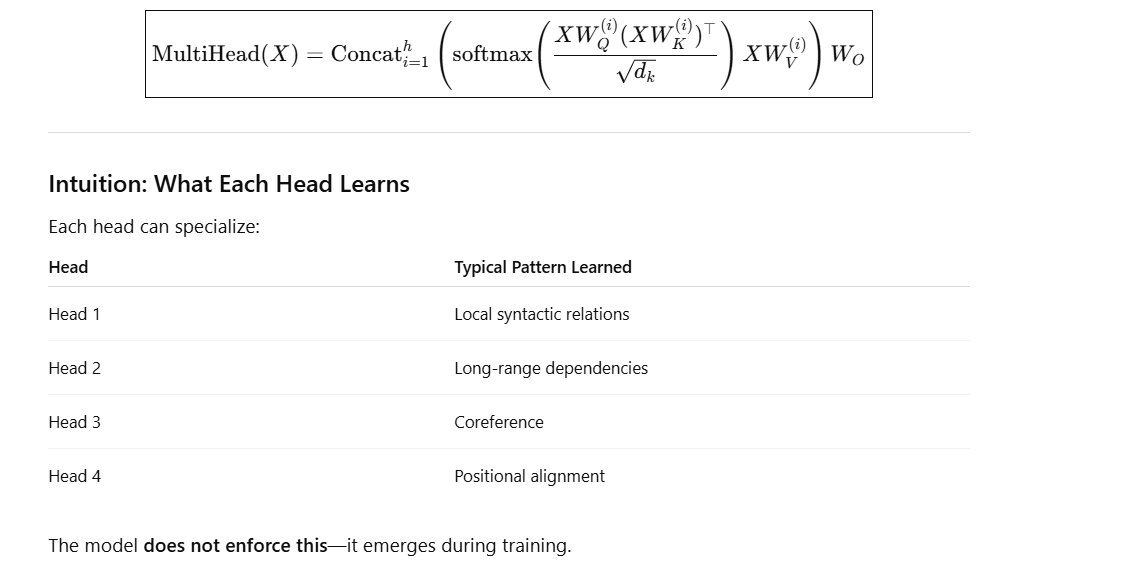


## 7. Transformer for Text Summarization (Conceptual Flow)

For a 1000-word paragraph:

1. Tokenize text  
2. Convert tokens to embeddings  
3. Add positional encoding  
4. Pass through Transformer Encoder layers  
5. Use a Decoder (or encoder-only model) to generate summary  

In practice, we use **pretrained Transformer models**.



## 8. Practical Example: Summarization Using a Transformer (Hugging Face)

We will use a **pretrained encoder-decoder Transformer**:
- `facebook/bart-large-cnn`
- Designed specifically for summarization

How Summarization Works in facebook/bart-large-cnn

facebook/bart-large-cnn is a sequence-to-sequence (encoder–decoder) Transformer model fine-tuned specifically for abstractive summarization on the CNN/DailyMail dataset. Its operation can be understood in four stages:

### 1. Architecture: Encoder–Decoder Transformer

Encoder: Reads the full input text and converts it into contextualized hidden representations using self-attention.

Decoder: Generates the summary token-by-token, attending both to previously generated tokens and to the encoder’s output.

This enables the model to paraphrase, compress, and reorganize information rather than simply extract sentences.

### 2. Pretraining via Denoising Autoencoding

BART is pretrained by:

Corrupting input text (masking, deleting, shuffling sentences)

Training the model to reconstruct the original text
This teaches the model:

- Language structure

- Long-range dependencies

- Content reconstruction

### 3. Fine-Tuning for Summarization

During fine-tuning on CNN/DailyMail:

- Input: Full news article

- Output: Human-written highlights (summaries)

The model learns:

- What information is salient

- How to compress content to ~3–4 sentences

- A neutral, news-style summarization tone


In [ ]:

# Install dependencies if needed
# !pip install transformers torch sentencepiece


In [3]:

from transformers import BartTokenizer, BartForConditionalGeneration

model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)


C:\Users\Suyashi144893\AppData\Local\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



## 9. Summarizing a Long (~1000 word) Paragraph

Important considerations:
- Transformers have **maximum token limits**
- BART supports ~1024 tokens
- For longer inputs, chunking or sliding windows are required


In [4]:

text = input("Enter you Text for summarization :")

inputs = tokenizer(
    text,
    max_length=1024,
    truncation=True,
    return_tensors="pt"
)

summary_ids = model.generate(
    inputs["input_ids"],
    num_beams=4,
    max_length=150,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
summary


Enter you Text for summarization :travel is one of the most enriching experiences a person can undertake, offering a unique blend of adventure, learning, and personal growth. It allows individuals to step outside their comfort zones and immerse themselves in new cultures, traditions, and landscapes. Whether it’s exploring the bustling streets of a metropolitan city, hiking through serene mountain trails, or relaxing on a sun-kissed beach, every journey brings a fresh perspective on life. Traveling fosters curiosity and broadens horizons, enabling people to appreciate diversity and understand the interconnectedness of the world. It’s not just about visiting famous landmarks; it’s about engaging with local communities, tasting authentic cuisines, and discovering stories that shape a region’s identity. Moreover, travel has a therapeutic effect—it helps reduce stress, sparks creativity, and strengthens relationships when shared with loved ones. In today’s fast-paced world, taking time to t

'Travel is one of the most enriching experiences a person can undertake. It allows individuals to step outside their comfort zones and immerse themselves in new cultures, traditions, and landscapes. Traveling fosters curiosity and broadens horizons, enabling people to appreciate diversity and understand the interconnectedness of the world.'


## 10. How Self-Attention Enables Summarization

During encoding:
- Each token attends to **all other tokens**
- Important sentences receive higher attention weights

During decoding:
- The model learns to generate **compressed semantic representations**
- Redundant or low-attention content is dropped

Mathematically:
\[
\text{Summary} = f(Attention(Z))
\]



## 11. Key Takeaways

- Positional encoding injects order into parallel processing
- Self-attention computes contextual relevance via dot products
- Transformers scale efficiently for long documents
- Pretrained models operationalize these ideas for summarization


